In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Paraná - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_PR.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Paraná - Desemprego,Paraná - value,Paraná - Produção de Cimento (t),Paraná - PIB - Estadual,Paraná - PIB - Construção Civil,Paraná - PIB - Per Capita,Paraná - PIB - Preços de Mercado,Paraná - IDH,Paraná - Consumo de Cimento (t)
0,2003-1,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,8.284196,0.300568,332.705560,2.027147e+08,1.060612e+07,17.589536,1.851788e+08,0.776871,189.804
1,2003-2,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,8.277973,0.301710,332.945945,2.029477e+08,1.061597e+07,17.592548,1.852326e+08,0.776975,174.713
2,2003-3,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,8.271750,0.302645,335.222130,2.031806e+08,1.062582e+07,17.595559,1.852864e+08,0.777079,180.801
3,2003-4,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,8.265527,0.303413,334.785737,2.034136e+08,1.063567e+07,17.598570,1.853401e+08,0.777183,180.172
4,2003-5,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,8.259304,0.304034,335.050185,2.036466e+08,1.064551e+07,17.601581,1.853939e+08,0.777287,185.597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.549782,616.073841,NaN,NaN,NaN,NaN,NaN,412.177
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.546864,614.423079,NaN,NaN,NaN,NaN,NaN,337.056
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.544541,613.772150,NaN,NaN,NaN,NaN,NaN,340.018
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.540629,614.761140,NaN,NaN,NaN,NaN,NaN,383.477


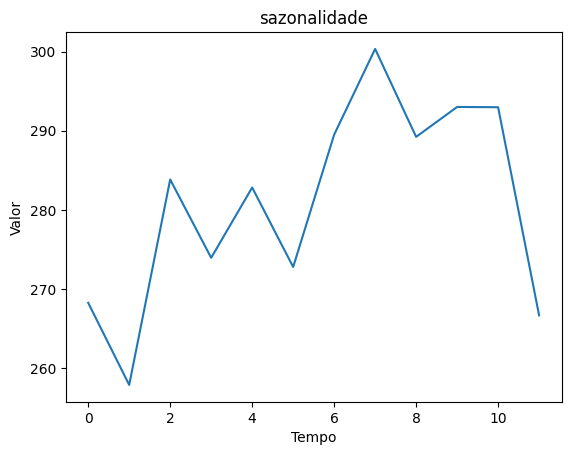

,sazonalidade
sazonalidade,
0,268.268214
1,257.896429
2,283.840571
3,273.950571
4,282.830429
5,272.791286
6,289.501500
7,300.332143
8,289.225643


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Paraná - Desemprego,Paraná - value,Paraná - Produção de Cimento (t),Paraná - PIB - Estadual,Paraná - PIB - Construção Civil,Paraná - PIB - Per Capita,Paraná - PIB - Preços de Mercado,Paraná - IDH,sazonalidade,Paraná - Consumo de Cimento (t)
0,2003-1,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,8.284196,0.300568,332.705560,2.027147e+08,1.060612e+07,17.589536,1.851788e+08,0.776871,268.268214,189.804
1,2003-2,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,8.277973,0.301710,332.945945,2.029477e+08,1.061597e+07,17.592548,1.852326e+08,0.776975,257.896429,174.713
2,2003-3,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,8.271750,0.302645,335.222130,2.031806e+08,1.062582e+07,17.595559,1.852864e+08,0.777079,283.840571,180.801
3,2003-4,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,8.265527,0.303413,334.785737,2.034136e+08,1.063567e+07,17.598570,1.853401e+08,0.777183,273.950571,180.172
4,2003-5,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,8.259304,0.304034,335.050185,2.036466e+08,1.064551e+07,17.601581,1.853939e+08,0.777287,282.830429,185.597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.549782,616.073841,NaN,NaN,NaN,NaN,NaN,300.332143,412.177
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.546864,614.423079,NaN,NaN,NaN,NaN,NaN,289.225643,337.056
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.544541,613.772150,NaN,NaN,NaN,NaN,NaN,293.003214,340.018
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.540629,614.761140,NaN,NaN,NaN,NaN,NaN,292.969214,383.477


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      172.044
1      188.841
2      200.253
3      188.916
4      184.994
        ...   
235        NaN
236        NaN
237        NaN
238        NaN
239        NaN
Name: Paraná - Consumo de Cimento (t), Length: 240, dtype: float64

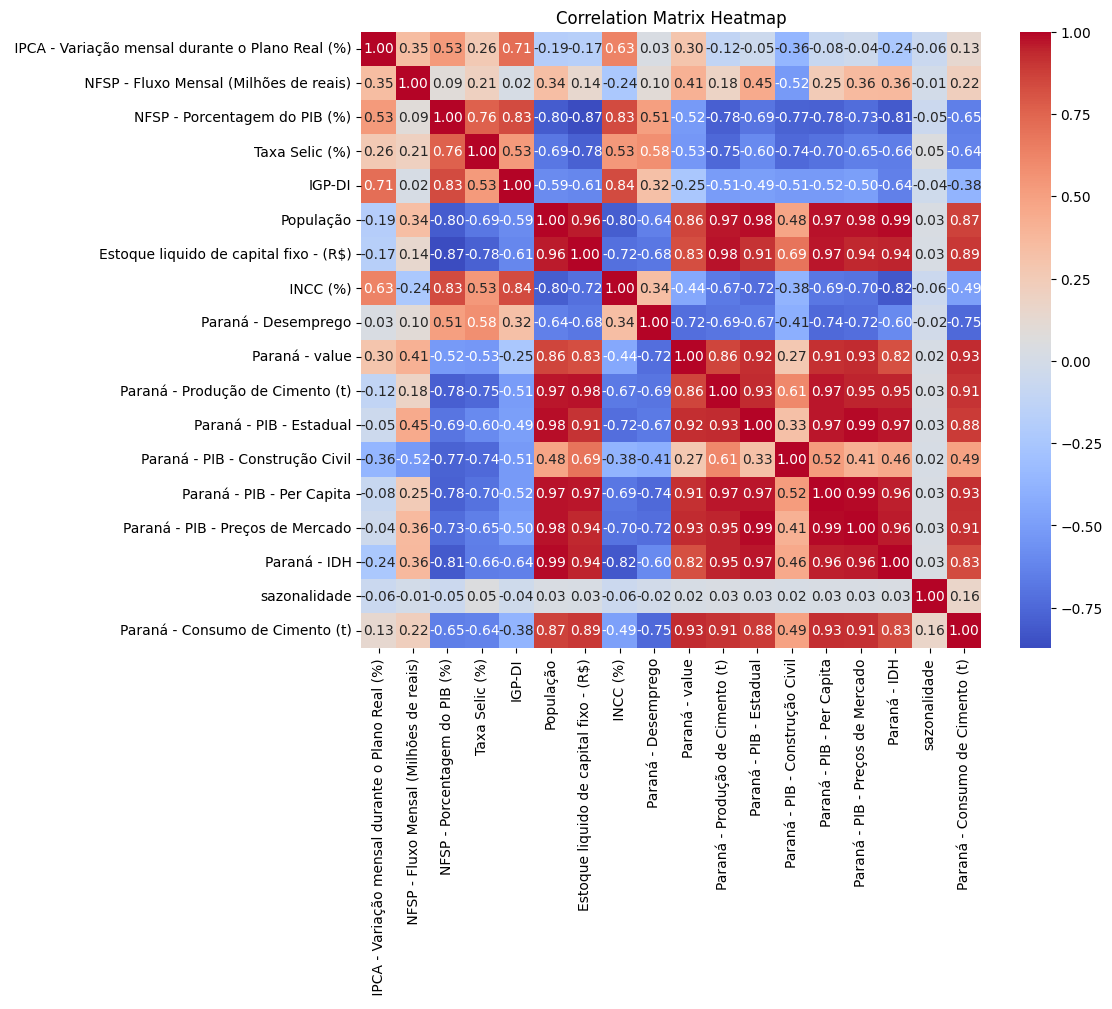

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.fillna(0.0).iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,IPCA - Variação mensal durante o Plano Real (%),2.689806e+03
1,NFSP - Fluxo Mensal (Milhões de reais),2.651731e+02
2,NFSP - Porcentagem do PIB (%),2.831957e+02
3,Taxa Selic (%),5.928536e+01
4,IGP-DI,3.594774e+02
5,População,1.731758e+06
6,Estoque liquido de capital fixo - (R$),1.984272e+07
7,INCC (%),1.817236e+03
8,Paraná - Desemprego,2.858581e+03
9,Paraná - value,8.874210e+03


In [39]:
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 4


,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,INCC (%),Paraná - Desemprego,Paraná - value,Paraná - Produção de Cimento (t),Paraná - PIB - Estadual,Paraná - PIB - Construção Civil,Paraná - IDH,sazonalidade
0,0.724032,-5331.049150,11.520143,1.639718,1.036534,0.969649,8.284196,0.300568,332.705560,2.027147e+08,1.060612e+07,0.776871,268.268214
1,0.690297,-5318.079644,11.189862,1.378899,0.993449,0.950783,8.277973,0.301710,332.945945,2.029477e+08,1.061597e+07,0.776975,257.896429
2,0.669681,-5436.417870,10.820792,1.924317,0.973020,0.938332,8.271750,0.302645,335.222130,2.031806e+08,1.062582e+07,0.777079,283.840571
3,0.660494,-5707.015274,10.417840,1.331174,0.940489,0.926401,8.265527,0.303413,334.785737,2.034136e+08,1.063567e+07,0.777183,273.950571
4,0.648337,-5599.317941,9.959690,1.736072,0.917493,0.951683,8.259304,0.304034,335.050185,2.036466e+08,1.064551e+07,0.777287,282.830429
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.366904,-5783.316460,2.206994,0.545067,0.471521,0.378150,7.487170,0.400855,493.627481,2.425332e+08,1.097704e+07,0.787082,300.332143
176,0.358935,-6001.730740,2.215328,0.782910,0.476827,0.377666,7.477752,0.401377,493.374474,2.424937e+08,1.097741e+07,0.787011,289.225643
177,0.354313,-6454.887704,2.232466,0.909682,0.475427,0.377838,7.468333,0.401647,494.637705,2.424541e+08,1.097778e+07,0.786939,293.003214
178,0.352728,-6243.191421,2.263185,1.050614,0.491301,0.370057,7.458915,0.402140,495.875938,2.424146e+08,1.097816e+07,0.786868,292.969214


In [40]:
input_data = data.fillna(0.0).iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
input_data = input_data.fillna(0.0)
input_data

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,INCC (%),Paraná - Desemprego,Paraná - value,Paraná - Produção de Cimento (t),Paraná - PIB - Estadual,Paraná - PIB - Construção Civil,Paraná - IDH
0,0.604311,4.268118,2.039314,3.921218,3.214079,1.135376,-0.928691,-1.637316,-1.606120,-2.340956,-2.091701
1,0.609431,4.096014,1.195209,3.582946,3.051841,1.121280,-0.910659,-1.633307,-1.589113,-2.294567,-2.058133
2,0.562720,3.903698,2.960381,3.422548,2.944772,1.107184,-0.895896,-1.595339,-1.572106,-2.248179,-2.024564
3,0.455907,3.693727,1.040752,3.167136,2.842174,1.093087,-0.883769,-1.602618,-1.555099,-2.201790,-1.990995
4,0.498418,3.454992,2.351150,2.986591,3.059587,1.078991,-0.873955,-1.598207,-1.538092,-2.155401,-1.957426
...,...,...,...,...,...,...,...,...,...,...,...
175,0.425789,-0.584804,-1.503380,-0.514871,-1.872446,-0.670068,0.655022,1.046917,1.300715,-0.593728,1.207515
176,0.339575,-0.580461,-0.733634,-0.473208,-1.876611,-0.691403,0.663269,1.042697,1.297829,-0.591970,1.184461
177,0.160702,-0.571531,-0.323353,-0.484199,-1.875135,-0.712739,0.667524,1.063768,1.294942,-0.590212,1.161407
178,0.244264,-0.555524,0.132757,-0.359568,-1.942040,-0.734074,0.675307,1.084422,1.292056,-0.588453,1.138352


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,INCC (%),Paraná - Desemprego,Paraná - value,Paraná - Produção de Cimento (t),Paraná - PIB - Estadual,Paraná - PIB - Construção Civil,Paraná - IDH
0,0.604311,4.268118,2.039314,3.921218,3.214079,1.135376,-0.928691,-1.637316,-1.606120,-2.340956,-2.091701
1,0.609431,4.096014,1.195209,3.582946,3.051841,1.121280,-0.910659,-1.633307,-1.589113,-2.294567,-2.058133
2,0.562720,3.903698,2.960381,3.422548,2.944772,1.107184,-0.895896,-1.595339,-1.572106,-2.248179,-2.024564
3,0.455907,3.693727,1.040752,3.167136,2.842174,1.093087,-0.883769,-1.602618,-1.555099,-2.201790,-1.990995
4,0.498418,3.454992,2.351150,2.986591,3.059587,1.078991,-0.873955,-1.598207,-1.538092,-2.155401,-1.957426
...,...,...,...,...,...,...,...,...,...,...,...
163,1.465326,-0.676734,0.472779,-1.087000,-1.491033,-0.249301,0.595872,0.882861,1.309485,-0.529993,1.474560
164,1.351131,-0.668750,0.302784,-0.904679,-1.525186,-0.303585,0.581998,0.897453,1.311772,-0.545202,1.453427
165,1.143146,-0.657609,0.339539,-0.900134,-1.546744,-0.357869,0.572513,0.913574,1.314059,-0.560410,1.432294
166,1.542609,-0.647588,0.472795,-1.136836,-1.586381,-0.412153,0.564328,0.928670,1.316346,-0.575619,1.411161


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      172.044
1      188.841
2      200.253
3      188.916
4      184.994
        ...   
163    344.937
164    302.082
165    294.467
166    336.029
167    278.117
Name: Paraná - Consumo de Cimento (t), Length: 168, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 11)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,INCC (%),Paraná - Desemprego,Paraná - value,Paraná - Produção de Cimento (t),Paraná - PIB - Estadual,Paraná - PIB - Construção Civil,Paraná - IDH
132,0.817451,-0.366715,-0.530011,0.174628,-0.066954,-0.726081,1.580396,0.875957,1.017465,0.234366,0.762919
133,1.130195,-0.350285,-0.532694,0.240832,-0.130652,-0.659857,1.592156,0.888756,1.031809,0.204543,0.757772
134,1.160498,-0.335122,-0.186421,0.176857,-0.079602,-0.593634,1.599280,0.883920,1.046154,0.174720,0.752625
135,1.131990,-0.321950,-0.719664,-0.005233,-0.034473,-0.527410,1.604093,0.878665,1.060499,0.144897,0.747478
136,1.384387,-0.302995,-0.798520,0.097576,-0.177535,-0.461187,1.607510,0.873061,1.074843,0.115074,0.742331
137,1.375487,-0.290554,-0.612129,0.431487,-0.208868,-0.394963,1.610217,0.866861,1.089188,0.085251,0.737184
138,1.438928,-0.281926,-0.476740,0.482414,-0.245300,-0.328740,1.603503,0.860358,1.103533,0.055428,0.732037
139,1.569590,-0.275931,-0.211736,0.657043,-0.333490,-0.262516,1.591542,0.853300,1.117877,0.025605,0.726890
140,1.584058,-0.271466,-0.484608,0.678386,-0.296846,-0.196292,1.574229,0.845929,1.132222,-0.004218,0.721743
141,1.166380,-0.273241,-0.183907,0.727143,-0.292462,-0.130069,1.554681,0.838255,1.146567,-0.034041,0.716596


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 11)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.14,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[713342389, 2026829685, 2566360291, 631439837, 817397834, 2048965265, 1959616305, 2664014317, 3861123686, 2040314377]


Step: 0 ___________________________________________
val_loss: 1180.215087890625
winner_seed: 713342389


Step: 1 ___________________________________________
val_loss: 1143.085693359375
winner_seed: 2026829685


Step: 2 ___________________________________________
val_loss: 1263.303466796875


Step: 3 ___________________________________________
val_loss: 1322.5687255859375


Step: 4 ___________________________________________
val_loss: 1462.6702880859375


Step: 5 ___________________________________________
val_loss: 7391852032.0


Step: 6 ___________________________________________
val_loss: 1468.1429443359375


Step: 7 ___________________________________________
val_loss: 123368552.0


Step: 8 ___________________________________________
val_loss: 1427.8529052734375


Step: 9 ___________________________________________
val_loss: 5861712.0


final_seed: 2026829685


In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 140ms/step - loss: 79546.4922 - val_loss: 1257.8821
Epoch 2/10000
4/4 [==============================] - 0s 11ms/step - loss: 2950.6641 - val_loss: 1174.6825
Epoch 3/10000
4/4 [==============================] - 0s 11ms/step - loss: 3142.1306 - val_loss: 2106.0554
Epoch 4/10000
4/4 [==============================] - 0s 11ms/step - loss: 2909.4175 - val_loss: 1576.6958
Epoch 5/10000
4/4 [==============================] - 0s 11ms/step - loss: 2722.8354 - val_loss: 1128.7583
Epoch 6/10000
4/4 [==============================] - 0s 11ms/step - loss: 2954.7961 - val_loss: 1635.2522
Epoch 7/10000
4/4 [==============================] - 0s 12ms/step - loss: 2370.7388 - val_loss: 1199.4778
Epoch 8/10000
4/4 [==============================] - 0s 12ms/step - loss: 2232.1226 - val_loss: 1957.7653
Epoch 9/10000
4/4 [==============================] - 0s 12ms/step - loss: 2367.8459 - val_loss: 1222.1169
Epoch 10/10000
4/4 [========================

4/4 [==============================] - 0s 12ms/step - loss: 601.2239 - val_loss: 1190.7841
Epoch 79/10000
4/4 [==============================] - 0s 12ms/step - loss: 552.9625 - val_loss: 1132.6377
Epoch 80/10000
4/4 [==============================] - 0s 12ms/step - loss: 518.4587 - val_loss: 1242.5966
Epoch 81/10000
4/4 [==============================] - 0s 12ms/step - loss: 534.7067 - val_loss: 1160.7474
Epoch 82/10000
4/4 [==============================] - 0s 12ms/step - loss: 647.5766 - val_loss: 1235.0917
Epoch 83/10000
4/4 [==============================] - 0s 12ms/step - loss: 496.2987 - val_loss: 1172.3356
Epoch 84/10000
4/4 [==============================] - 0s 12ms/step - loss: 495.1352 - val_loss: 1203.9027
Epoch 85/10000
4/4 [==============================] - 0s 12ms/step - loss: 515.5706 - val_loss: 1198.5830
Epoch 86/10000
4/4 [==============================] - 0s 12ms/step - loss: 527.4222 - val_loss: 1177.1346
Epoch 87/10000
4/4 [==============================] - 0s 12ms

Epoch 155/10000
4/4 [==============================] - 0s 11ms/step - loss: 746.1222 - val_loss: 1599.5583
Epoch 156/10000
4/4 [==============================] - 0s 11ms/step - loss: 591.5005 - val_loss: 1144.7211
Epoch 157/10000
4/4 [==============================] - 0s 12ms/step - loss: 614.1180 - val_loss: 1605.1372
Epoch 158/10000
4/4 [==============================] - 0s 11ms/step - loss: 874.2283 - val_loss: 1138.3486
Epoch 159/10000
4/4 [==============================] - 0s 11ms/step - loss: 763.2290 - val_loss: 1192.0143
Epoch 160/10000
4/4 [==============================] - 0s 11ms/step - loss: 585.0278 - val_loss: 1153.5498
Epoch 161/10000
4/4 [==============================] - 0s 11ms/step - loss: 524.0431 - val_loss: 1249.8074
Epoch 162/10000
4/4 [==============================] - 0s 12ms/step - loss: 497.8807 - val_loss: 1221.5847
Epoch 163/10000
4/4 [==============================] - 0s 12ms/step - loss: 569.9307 - val_loss: 1358.3699
Epoch 164/10000
4/4 [================

4/4 [==============================] - 0s 13ms/step - loss: 618.1813 - val_loss: 1174.1315
Epoch 308/10000
4/4 [==============================] - 0s 12ms/step - loss: 501.7511 - val_loss: 1138.9365
Epoch 309/10000
4/4 [==============================] - 0s 12ms/step - loss: 479.6204 - val_loss: 1145.6804
Epoch 310/10000
4/4 [==============================] - 0s 12ms/step - loss: 444.6898 - val_loss: 1167.4036
Epoch 311/10000
4/4 [==============================] - 0s 12ms/step - loss: 436.8676 - val_loss: 1249.0760
Epoch 312/10000
4/4 [==============================] - 0s 12ms/step - loss: 573.4653 - val_loss: 1236.0890
Epoch 313/10000
4/4 [==============================] - 0s 11ms/step - loss: 514.1042 - val_loss: 1235.9677
Epoch 314/10000
4/4 [==============================] - 0s 11ms/step - loss: 472.7235 - val_loss: 1145.5712
Epoch 315/10000
4/4 [==============================] - 0s 10ms/step - loss: 452.5041 - val_loss: 1129.7452
Epoch 316/10000
4/4 [==============================] 

4/4 [==============================] - 0s 10ms/step - loss: 427.9762 - val_loss: 1147.9901
Epoch 460/10000
4/4 [==============================] - 0s 11ms/step - loss: 408.3755 - val_loss: 1744.0818
Epoch 461/10000
4/4 [==============================] - 0s 11ms/step - loss: 659.4790 - val_loss: 1418.6768
Epoch 462/10000
4/4 [==============================] - 0s 11ms/step - loss: 440.4156 - val_loss: 1482.2355
Epoch 463/10000
4/4 [==============================] - 0s 12ms/step - loss: 412.7104 - val_loss: 1994.5802
Epoch 464/10000
4/4 [==============================] - 0s 12ms/step - loss: 428.2304 - val_loss: 1272.6068
Epoch 465/10000
4/4 [==============================] - 0s 11ms/step - loss: 398.2598 - val_loss: 1273.8497
Epoch 466/10000
4/4 [==============================] - 0s 11ms/step - loss: 442.5315 - val_loss: 1981.1019
Epoch 467/10000
4/4 [==============================] - 0s 12ms/step - loss: 630.7777 - val_loss: 1180.2474
Epoch 468/10000
4/4 [==============================] 

Epoch 612/10000
4/4 [==============================] - 0s 10ms/step - loss: 358.5217 - val_loss: 1486.1228
Epoch 613/10000
4/4 [==============================] - 0s 9ms/step - loss: 320.5897 - val_loss: 1312.0980
Epoch 614/10000
4/4 [==============================] - 0s 11ms/step - loss: 320.6167 - val_loss: 1330.3936
Epoch 615/10000
4/4 [==============================] - 0s 11ms/step - loss: 329.3803 - val_loss: 1377.3407
Epoch 616/10000
4/4 [==============================] - 0s 10ms/step - loss: 299.3664 - val_loss: 1397.9851
Epoch 617/10000
4/4 [==============================] - 0s 11ms/step - loss: 287.1352 - val_loss: 1303.1259
Epoch 618/10000
4/4 [==============================] - 0s 11ms/step - loss: 314.8162 - val_loss: 1181.3728
Epoch 619/10000
4/4 [==============================] - 0s 13ms/step - loss: 253.3310 - val_loss: 1399.5259
Epoch 620/10000
4/4 [==============================] - 0s 10ms/step - loss: 238.1111 - val_loss: 1414.5614
Epoch 621/10000
4/4 [=================

Epoch 765/10000
4/4 [==============================] - 0s 10ms/step - loss: 488.4799 - val_loss: 1579.6853
Epoch 766/10000
4/4 [==============================] - 0s 10ms/step - loss: 456.8931 - val_loss: 1580.7778
Epoch 767/10000
4/4 [==============================] - 0s 10ms/step - loss: 417.1774 - val_loss: 1471.3939
Epoch 768/10000
4/4 [==============================] - 0s 10ms/step - loss: 467.5228 - val_loss: 1543.5402
Epoch 769/10000
4/4 [==============================] - 0s 10ms/step - loss: 488.0455 - val_loss: 1435.5343
Epoch 770/10000
4/4 [==============================] - 0s 10ms/step - loss: 435.6777 - val_loss: 1787.1824
Epoch 771/10000
4/4 [==============================] - 0s 10ms/step - loss: 488.7719 - val_loss: 1711.1484
Epoch 772/10000
4/4 [==============================] - 0s 10ms/step - loss: 459.5452 - val_loss: 1609.8259
Epoch 773/10000
4/4 [==============================] - 0s 11ms/step - loss: 427.6924 - val_loss: 1493.3799
Epoch 774/10000
4/4 [================

4/4 [==============================] - 0s 12ms/step - loss: 361.4014 - val_loss: 1747.5804
Epoch 918/10000
4/4 [==============================] - 0s 11ms/step - loss: 355.3018 - val_loss: 1410.5417
Epoch 919/10000
4/4 [==============================] - 0s 11ms/step - loss: 510.2538 - val_loss: 1577.0682
Epoch 920/10000
4/4 [==============================] - 0s 12ms/step - loss: 395.1752 - val_loss: 1466.2102
Epoch 921/10000
4/4 [==============================] - 0s 12ms/step - loss: 416.5175 - val_loss: 1668.0594
Epoch 922/10000
4/4 [==============================] - 0s 11ms/step - loss: 361.7082 - val_loss: 1596.8334
Epoch 923/10000
4/4 [==============================] - 0s 12ms/step - loss: 347.5865 - val_loss: 1405.0988
Epoch 924/10000
4/4 [==============================] - 0s 11ms/step - loss: 340.6754 - val_loss: 1596.4443
Epoch 925/10000
4/4 [==============================] - 0s 11ms/step - loss: 365.8415 - val_loss: 1637.1780
Epoch 926/10000
4/4 [==============================] 

4/4 [==============================] - 0s 12ms/step - loss: 330.8756 - val_loss: 1666.2078
Epoch 1070/10000
4/4 [==============================] - 0s 12ms/step - loss: 395.4649 - val_loss: 1682.8223
Epoch 1071/10000
4/4 [==============================] - 0s 12ms/step - loss: 297.0378 - val_loss: 1603.5278
Epoch 1072/10000
4/4 [==============================] - 0s 12ms/step - loss: 307.4040 - val_loss: 1628.2908
Epoch 1073/10000
4/4 [==============================] - 0s 13ms/step - loss: 257.2611 - val_loss: 1703.0482
Epoch 1074/10000
4/4 [==============================] - 0s 12ms/step - loss: 316.4878 - val_loss: 1611.0447
Epoch 1075/10000
4/4 [==============================] - 0s 12ms/step - loss: 290.6678 - val_loss: 1733.9180
Epoch 1076/10000
4/4 [==============================] - 0s 11ms/step - loss: 276.7933 - val_loss: 1655.6857
Epoch 1077/10000
4/4 [==============================] - 0s 11ms/step - loss: 248.8973 - val_loss: 1592.5165
Epoch 1078/10000
4/4 [=======================

4/4 [==============================] - 0s 11ms/step - loss: 246.3604 - val_loss: 1682.3633
Epoch 1146/10000
4/4 [==============================] - 0s 11ms/step - loss: 370.7332 - val_loss: 1694.0052
Epoch 1147/10000
4/4 [==============================] - 0s 10ms/step - loss: 396.0872 - val_loss: 1969.0101
Epoch 1148/10000
4/4 [==============================] - 0s 11ms/step - loss: 317.9124 - val_loss: 1687.2513
Epoch 1149/10000
4/4 [==============================] - 0s 11ms/step - loss: 276.9371 - val_loss: 1675.2950
Epoch 1150/10000
4/4 [==============================] - 0s 11ms/step - loss: 283.8230 - val_loss: 1820.8372
Epoch 1151/10000
4/4 [==============================] - 0s 11ms/step - loss: 278.7278 - val_loss: 1566.7448
Epoch 1152/10000
4/4 [==============================] - 0s 11ms/step - loss: 247.8083 - val_loss: 1723.3799
Epoch 1153/10000
4/4 [==============================] - 0s 11ms/step - loss: 258.7539 - val_loss: 1567.6455
Epoch 1154/10000
4/4 [=======================

4/4 [==============================] - 0s 12ms/step - loss: 405.5753 - val_loss: 1647.5591
Epoch 1222/10000
4/4 [==============================] - 0s 18ms/step - loss: 237.1585 - val_loss: 1600.9637
Epoch 1223/10000
4/4 [==============================] - 0s 12ms/step - loss: 206.9756 - val_loss: 1602.4053
Epoch 1224/10000
4/4 [==============================] - 0s 12ms/step - loss: 217.1410 - val_loss: 1600.9342
Epoch 1225/10000
4/4 [==============================] - 0s 11ms/step - loss: 230.3112 - val_loss: 1649.0774
Epoch 1226/10000
4/4 [==============================] - 0s 11ms/step - loss: 306.3281 - val_loss: 1775.7263
Epoch 1227/10000
4/4 [==============================] - 0s 11ms/step - loss: 313.4903 - val_loss: 1542.2976
Epoch 1228/10000
4/4 [==============================] - 0s 11ms/step - loss: 219.7296 - val_loss: 1603.9802
Epoch 1229/10000
4/4 [==============================] - 0s 11ms/step - loss: 195.9482 - val_loss: 1567.5330
Epoch 1230/10000
4/4 [=======================

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 16ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,321.725555,334.861969,326.793213,333.246979,337.891876,341.836761,321.256622,346.031494,346.090485,339.892365,341.15036,335.885071
Target,323.005,291.453,300.203,317.058,314.142,301.878,358.797,356.169,316.188,346.214,323.401,238.466
Error,1.279449,43.408966,26.59021,16.188965,23.749878,39.958771,37.540375,10.137512,29.902496,6.321625,17.749359,97.419067


In [54]:
display(mae)
display(mape)

29.187223

0.10081952

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input.iloc[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             test_input, 
                                             test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

NameError: name 'test_target' is not defined